# Process and grade LLM responses

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from typing import NamedTuple
import numpy as np

In [2]:
ROOT = os.path.expanduser("~/biodiversity-llms")
TAXONOMY_TESTSET_SCORES = ROOT + "/tdwg2023/taxonomy/results/kpfg_scores.tsv"
TAXON_COUNTS = ROOT + "/tdwg2023/taxonomy/results/taxon-counts.tsv"

In [3]:
class Files(NamedTuple):
    responses: str

class Env(NamedTuple):
    files: Files
    num_phrasings: int
    phrasings: list[str]
    query_fields: list[str]

if "snakemake" in globals():
    env = Env(
        files=snakemake.input,
        num_phrasings=len(snakemake.params.phrasings),
        phrasings=snakemake.params.phrasings,
        query_fields=snakemake.params.query_fields
    )
else: # Fill in parameters manually for testing outside of snakemake
    env = Env(
        files = Files(
            responses="../../results/llama2-7b-chat/all-shuffled.tsv"
        ),
        num_phrasings=6,
        phrasings=[
            "Can species {genus} {specificepithet} be found in {county}, {stateprovince}, {country}?",
            "Is it possible to encounter species {genus} {specificepithet} in {county}, {stateprovince}, {country}?",
            "Is there a presence of species {genus} {specificepithet} within {county}, {stateprovince}, {country}?",
            "Does {county}, {stateprovince}, {country} harbor species {genus} {specificepithet}?",
            "Is species {genus} {specificepithet} present in {county}, {stateprovince}, {country}?",
            "Can one observe species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
        ],
        query_fields=[
            "kingdom",
            "phylum",
            "family",
            "genus",
            "specificepithet",
            "country",
            "stateprovince",
            "county"
        ]
    )

def nest(level, strings):
    separator = "\n" + "  " * level + "- "
    return separator + separator.join([str(s) for s in strings])

def quote(strings):
    return [f'"{s}"' for s in strings]

print("Job parameters:")
print(f"- Responses to analyze: {env.files.responses}")
print(f"- Query phrasings (count: {env.num_phrasings}):{nest(2, quote(env.phrasings))}")
print(f"- Query fields:{nest(2, quote(env.query_fields))}")


Job parameters:
- Responses to analyze: ../../results/llama2-7b-chat/all-shuffled.tsv
- Query phrasings (count: 6):
    - "Can species {genus} {specificepithet} be found in {county}, {stateprovince}, {country}?"
    - "Is it possible to encounter species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
    - "Is there a presence of species {genus} {specificepithet} within {county}, {stateprovince}, {country}?"
    - "Does {county}, {stateprovince}, {country} harbor species {genus} {specificepithet}?"
    - "Is species {genus} {specificepithet} present in {county}, {stateprovince}, {country}?"
    - "Can one observe species {genus} {specificepithet} in {county}, {stateprovince}, {country}?"
- Query fields:
    - "kingdom"
    - "phylum"
    - "family"
    - "genus"
    - "specificepithet"
    - "country"
    - "stateprovince"
    - "county"


In [4]:
def count_item(values, item):
    counts = dict(Counter(values).most_common())
    return counts[item] if item in counts else 0

def make_id(df):
    return df.apply(lambda r: hash("".join([str(v) for v in r.values]).lower()), axis=1)

def get_results(responses):
    df = pd.read_csv(open(responses), sep="\t")

    df["phrasing"] = df["question number"].astype(int) % env.num_phrasings
    df["target"] = (df["present"] == "Yes").astype(int) * 2 - 1
    df["query id"] = make_id(df[env.query_fields])

    df["response id"] = make_id(df[["query id", "phrasing"]])
    df = df.groupby("response id").head(1) # Drop responses for repeated questions

    df["first token top scores"] = df["first token top scores"].map(lambda x: eval(x))
    df["first token top strings"] = df["first token top strings"].map(lambda x: [s.lower() for s in eval(x)])

    df["no score"] = df.apply(lambda r: dict(zip(r["first token top strings"], r["first token top scores"])).get("no", -np.inf), axis=1).astype(np.float32)
    df["yes score"] = df.apply(lambda r: dict(zip(r["first token top strings"], r["first token top scores"])).get("yes", -np.inf), axis=1).astype(np.float32)
    
    from scipy.special import softmax
    def smax(x):
        return softmax(np.array(x).astype(float))
    
    df["no softmax"] = df.apply(lambda r: dict(zip(r["first token top strings"], smax(r["first token top scores"]))).get("no", 0), axis=1).astype(np.float32)
    df["yes softmax"] = df.apply(lambda r: dict(zip(r["first token top strings"], smax(r["first token top scores"]))).get("yes", 0), axis=1).astype(np.float32)

    df["prediction"] = (df["yes softmax"] > 0).astype(int) * 2 - 1 # Note that all response started with either "Yes" or "No"
    # df["prediction"] = df["first token top strings"].map(lambda x: {"yes": 1, "no": -1}.get(x[0], 0))
    #.map(lambda x: random.choice([-1, 1]))
    
    df["correct"] = df["prediction"] * df["target"]

    return df

UNUSED_FIELDS = ["query"]
res = get_results(env.files.responses)\
    .drop(columns=UNUSED_FIELDS)

# Drop fungi
res = res[~(res["kingdom"] == "fungi")]

# Drop records with the same family and genus, they cause headaches later
res = res[res["genus"].apply(lambda s: s.lower()) != res["family"].apply(lambda s: s.lower())]

print(f"{len(res) / env.num_phrasings:,.0f} records")
print(f"{len(res):,.0f} queries (#records x #phrasings)")
res.head(1)

23,491 records
140,946 queries (#records x #phrasings)


,kingdom,phylum,family,genus,specificepithet,country,stateprovince,county,present,response,...,phrasing,target,query id,response id,no score,yes score,no softmax,yes softmax,prediction,correct
7,animalia,porifera,microcionidae,Clathria,aculeofila,Mexico,Nayarit,Bahia De Banderas,Yes,'Yes.',...,2,1,7277939327479650153,1596428960311568974,-inf,33.958,0.0,1.0,1,1


In [5]:
def womp(x):
    return x.astype(int) * 2 - 1

thresholds = np.arange(0, .01, .00005)
perf_all = np.array(list(map(lambda t: (womp(res["yes softmax"] >= t) == res["target"]).mean(), thresholds)))
perf_yes = np.array(list(map(lambda t: (womp(res["yes softmax"] >= t) == res["target"])[res["yes softmax"] >= t].mean(), thresholds)))
perf_no  = np.array(list(map(lambda t: (womp(res["yes softmax"] >= t) == res["target"])[res["yes softmax"] < t].mean(), thresholds)))

In [6]:
np.argmax(perf_all)

1

In [7]:
kpfg_scores = pd.read_csv(open(TAXONOMY_TESTSET_SCORES, "r"), sep="\t")
kpfg_scores["accuracy"] = (1 + kpfg_scores["num_correct"]) / (2 + kpfg_scores["num_response"])
kpfg_scores = kpfg_scores.set_index(["subject rank", "taxon"])
record_counts_by_taxon = pd.read_csv(open(TAXON_COUNTS, "r"), sep="\t").set_index(["kingdom", "phylum", "family"])

In [8]:
phrasing_avg_pred = res.groupby("query id")["prediction"].mean()
phrasing_var_score_no = res.groupby("query id")["no softmax"].var() # Can't compute variance of unnormalized scores when they include -infinity
phrasing_var_score_yes = res.groupby("query id")["yes softmax"].var()
phrasing_var_score = phrasing_var_score_no + phrasing_var_score_yes # TODO: just trying things out!

In [9]:
def show_accuracies(df, field, title, remap_values={}, format="{:,.2%}"):
    df = pd.DataFrame(
        (df.groupby(field)["correct"].mean() * .5 + .5)
        .rename("Response accuracy")
    ).transpose()
    df.columns.name = title
    df.rename(columns=remap_values, inplace=True)

    display(df.style.format(format))

show_accuracies(res, "phrasing", "Phrasing")
show_accuracies(res, "target", "Actual presence", remap_values={-1: "Absent", 1: "Present"})
show_accuracies(res, "prediction", "Predicted presence", remap_values={-1: "Absent", 1: "Present"})
show_accuracies(res, "kingdom", "Kingdom")

Phrasing,0,1,2,3,4,5
Response accuracy,54.56%,54.34%,55.10%,54.82%,54.93%,54.90%


Actual presence,Absent,Present
Response accuracy,70.92%,39.62%


Predicted presence,Absent,Present
Response accuracy,52.44%,59.21%


Kingdom,animalia,plantae
Response accuracy,52.53%,57.64%


In [10]:
df = res
df = df[(df["correct"] != 0) * (df["phrasing"] == 0)]

def get_acc_by_field(d, field, smoothing=1):
    num_records = d.groupby(field).size()
    num_correct = smoothing + d[d["correct"] == 1].groupby(field).size().reindex(num_records.index).fillna(0)
    num_incorrect = smoothing + d[d["correct"] == -1].groupby(field).size().reindex(num_records.index).fillna(0)
    return num_correct / (num_correct + num_incorrect)

acc_by_rank = pd.Series({rank: get_acc_by_field(df, rank) for rank in ["kingdom", "phylum", "family"]})
acc_by_country = get_acc_by_field(df, "country")
acc_by_stateprovince = get_acc_by_field(df, "stateprovince")

def get_ums(instance):
    # TODO: condition um3 on prediction?
    um5 = record_counts_by_taxon.loc[instance["kingdom"], instance["phylum"], instance["family"]]

    # Positively oriented, i.e. higher values = more certainty
    return pd.Series({
        "um1_prediction_score": instance["yes score"] if instance["prediction"] == 1 else instance["no score"],
        "um1_prediction_softmax": instance["yes softmax"] if instance["prediction"] == 1 else instance["no softmax"],
        "um1_present": instance["yes softmax"] if instance["prediction"] == 1 else 0,
        "um1_absent": instance["no softmax"] if instance["prediction"] == -1 else 0,
        "um1_present_raw": max(0, instance["yes score"]) if instance["prediction"] == 1 else 0,
        "um1_absent_raw": max(0, instance["no score"]) if instance["prediction"] == -1 else 0,
        "um3_kingdom": acc_by_rank["kingdom"][instance["kingdom"]],
        "um3_phylum": acc_by_rank["phylum"][instance["phylum"]],
        "um3_family": acc_by_rank["family"][instance["family"]],
        "um3_country": acc_by_country[instance["country"]],
        "um3_stateprovince": acc_by_stateprovince[instance["stateprovince"]],
        "um4_agreement": phrasing_avg_pred[instance["query id"]] * -instance["prediction"],
        "um4_score_var": phrasing_var_score[instance["query id"]],
        "um5_kingdom": um5["kingdomCount"],
        "um5_phylum": um5["phylumCount"],
        "um5_family": um5["familyCount"],
        "um6_phylum": kpfg_scores["accuracy"]["phylum"][instance["phylum"].lower()],
        "um6_family": kpfg_scores["accuracy"]["family"][instance["family"].lower()],
        "um6_genus": kpfg_scores["accuracy"]["genus"][instance["genus"].lower()],
        "um7_phylum": kpfg_scores["num_response"]["phylum"][instance["phylum"].lower()] / 10,
        "um7_family": kpfg_scores["num_response"]["family"][instance["family"].lower()] / 40,
        "um7_genus": kpfg_scores["num_response"]["genus"][instance["genus"].lower()] / 50,
    })

train_df = pd.concat([df.apply(lambda row: get_ums(row), axis=1), df], axis=1)

In [14]:
train_kingdoms = [
    "animalia",
    "plantae",
    # "fungi"
]

test_kingdoms = [
    "animalia",
    # "plantae",
    # "fungi"
]

test_fraction = .5

features = [
    "um1_prediction_score",
    "um1_prediction_softmax",
    "um1_present", # um1: scores
    "um1_absent",
    "um1_present_raw",
    "um1_absent_raw",
    # "um2", # um2: number of abstains
    "um3_kingdom", # um3: accuracy by field values
    "um3_phylum",
    # 'um3_family', # This is probably too much cheating
    "um3_country",
    "um3_stateprovince",
    "um4_agreement", # Variance in scores with phrasing changes
    "um4_score_var",
    'um5_kingdom', # um5: iDigBio record counts by taxonomic ranks
    'um5_phylum',
    'um5_family',
    "um6_phylum", # Accuracy on taxonomy questions
    "um6_family",
    "um6_genus",
    "um7_phylum", # Number of yes-no responses to taxonomy questions
    "um7_family",
    "um7_genus",
]

predictions = {
    -1,
     1
}

only_valid_absences = True

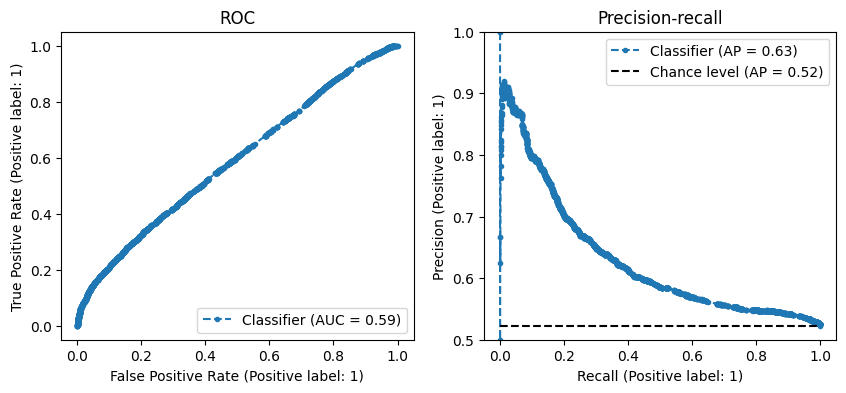

In [15]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
roc_args = {"marker":".", "linestyle":"--"}

if only_valid_absences and "valid" in train_df:
    tdf = train_df[train_df["valid"]]
else:
    tdf = train_df

if len(train_kingdoms) > 0:
    train_set = tdf[tdf["kingdom"].isin(train_kingdoms)]
    test_set = tdf[tdf["kingdom"].isin(test_kingdoms)]
else:
    train_set, test_set = train_test_split(
        tdf[tdf["kingdom"].isin(test_kingdoms) * tdf["prediction"].isin(predictions)],
        test_size=test_fraction
    )

xgboost = HistGradientBoostingClassifier(
    loss='log_loss',
    # early_stopping=True,
    min_samples_leaf=1,
    max_iter=100,
    monotonic_cst=np.ones_like(features, dtype=int)
).fit(train_set[features], train_set["correct"]) # categorical_features=["stateprovince"]

k = test_kingdoms
f, axes = plt.subplots(len(k), 2, figsize=(10, 4 * len(k)))

if len(k) == 1:
    axes = [axes]

axes[0][0].title.set_text(f"ROC")
axes[0][1].title.set_text(f"Precision-recall")

for i, ik in enumerate(k):
    ts = test_set[test_set["kingdom"] == ik]
    probs = xgboost.predict_proba(ts[features])
    RocCurveDisplay.from_predictions(ts["correct"], probs[:,1], ax=axes[i][0], **roc_args);
    disp = PrecisionRecallDisplay.from_predictions(
        ts["correct"], probs[:,1], plot_chance_level=True, drop_intermediate=True, ax=axes[i][1], drawstyle="default", **roc_args
    )
    # axes[i][1].set_xlim(0.01, 1)
    axes[i][1].set_ylim(0.5, 1)
    axes[i][1].legend()
plt.show()

In [13]:
train_df["certainty"] = xgboost.predict_proba(train_df[features])[:,1]
train_df.to_csv("../../results/llama2.tsv", sep="\t")

In [14]:
df[df["kingdom"] == "animalia"]["phylum"].value_counts()

phylum
mollusca         1770
arthropoda       1754
annelida         1753
chordata         1693
brachiopoda      1492
bryozoa          1248
echinodermata    1195
porifera         1139
cnidaria         1127
Name: count, dtype: int64

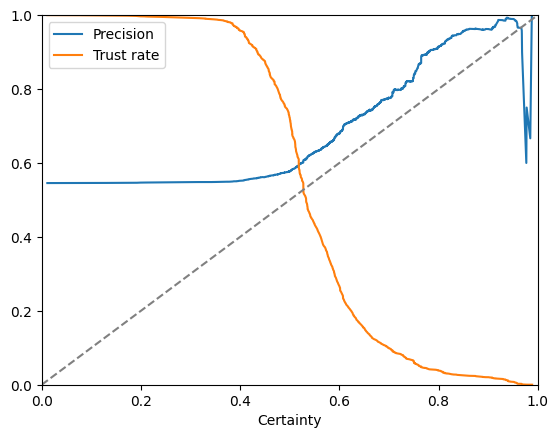

In [15]:
ts = test_set
ts["certainty"] = xgboost.predict_proba(ts[features])[:,1]
ts["correct"] = ts["correct"].clip(0,1)
ts = ts.sort_values("certainty")

pd.DataFrame({
    "Certainty": ts["certainty"],
    "Precision": [ts[ts["certainty"] >= c]["correct"].mean() for c in ts["certainty"]],
    "Trust rate": [ts[ts["certainty"] >= c].index.size / ts.index.size for c in ts["certainty"]]
}).set_index("Certainty").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [18]:
conf_model = (
    # "isotonic"
    "logistic"
)
calibration_set = (
    train_set
    # test_set
)

TODO - It would be better to calibrate on a subset, then test the calibration on the rest

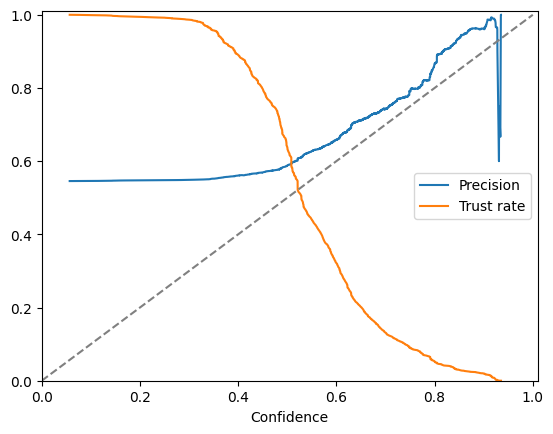

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

# Learn confidence function
rs = calibration_set.copy()
rs["certainty"] = xgboost.predict_proba(rs[features])[:,1]
rs["correct"] = rs["correct"].clip(0,1)
rs = rs.sort_values("certainty")

if conf_model == "isotonic":
    ir = IsotonicRegression(out_of_bounds="clip").fit(rs["certainty"].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: ir.transform(x) 
elif conf_model == "logistic":
    lr = LogisticRegression().fit(rs[["certainty"]].to_numpy(), rs["correct"].to_numpy())
    calibrate = lambda x: lr.predict_proba(x.reshape(-1, 1) if type(x) == np.ndarray else x.to_numpy().reshape(-1, 1))[:,1]
else:
    calibrate = lambda x: 0
    uhoh

# Plot confidence vs. precision
ts["confidence"] = calibrate(ts["certainty"])

pd.DataFrame({
    "Confidence": ts["confidence"],
    "Precision": [ts[ts["confidence"] >= c]["correct"].mean() for c in ts["confidence"]],
    "Trust rate": [ts[ts["confidence"] >= c].index.size / ts.index.size for c in ts["confidence"]]
}).set_index("Confidence").plot()

# Well-calibrated reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.legend(loc="center right")
plt.show()

In [20]:
calibration_args = {
    "n_bins": 100,
    "strategy": (
        # "uniform"
        "quantile"
    )
}

Certainty ECE: 0.03450961109285133
Confidence ECE: 0.04616179237376918


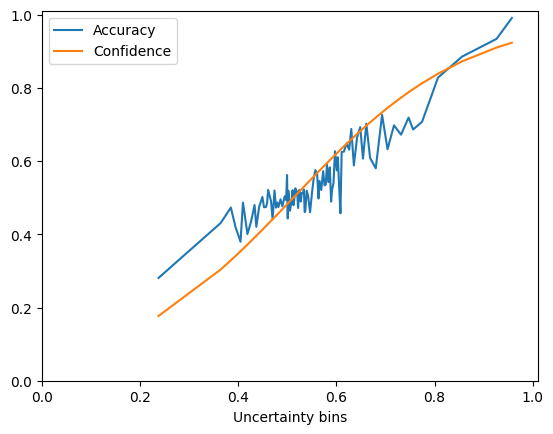

In [21]:
args = calibration_args | { "pos_label": 1, "y_true": ts["correct"] }
cert_prob_true, cert = calibration_curve(y_prob=ts["certainty"], **args)
conf_prob_true, conf = calibration_curve(y_prob=ts["confidence"], **args)

print("Certainty ECE:", abs(cert - cert_prob_true).sum() / len(cert))
print("Confidence ECE:", abs(conf - conf_prob_true).sum() / len(conf))

plt.plot(cert, cert_prob_true, label="Accuracy")
plt.plot(cert, calibrate(cert), label="Confidence")
plt.xlabel("Uncertainty bins")
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.legend()
plt.show()

array([[<Axes: title={'center': 'certainty'}>,
        <Axes: title={'center': 'confidence'}>]], dtype=object)

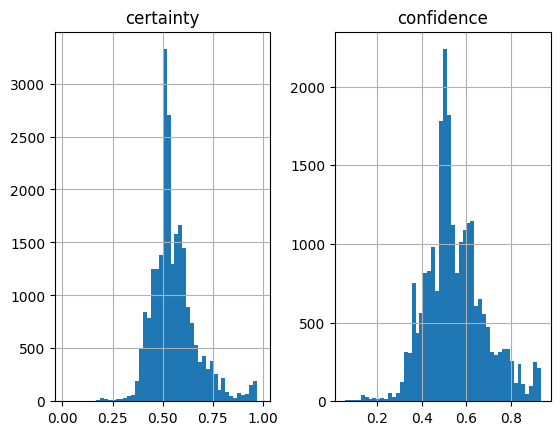

In [22]:
ts[["certainty", "confidence"]].hist(bins=50)